<a href="https://colab.research.google.com/github/2019mohamed/Team3-Project/blob/master/Object%20matching/Weak_object_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install timm

     |████████████████████████████████| 376 kB 5.5 MB/s 


In [ ]:
import cv2
import torch
import matplotlib.pyplot as plt

In [ ]:
#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Downloading: "https://github.com/intel-isl/MiDaS/archive/master.zip" to /root/.cache/torch/hub/master.zip


Loading weights:  None


Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.com/intel-isl/MiDaS/releases/download/v2_1/model-small-70d6b9c8.pt" to /root/.cache/torch/hub/checkpoints/model-small-70d6b9c8.pt


  0%|          | 0.00/81.8M [00:00<?, ?B/s]

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

MidasNet_small(
  (pretrained): Module(
    (layer1): Sequential(
      (0): Conv2dSameExport(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
      (3): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU6(inplace=True)
          (se): Identity()
          (conv_pw): Conv2d(32, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act2): Identity()
        )
      )
      (4): Sequential(
        (0): InvertedResidual(
          (conv_pw): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(144,

In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


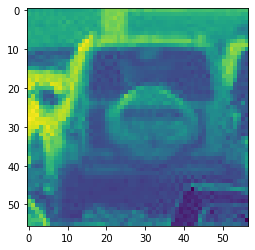

(343, 94) (400, 150)


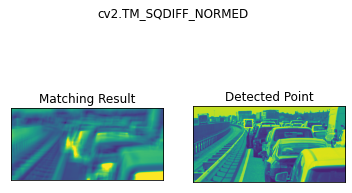

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('car.png',0)
plt.imshow(img)
img2 = img.copy()
template = cv2.imread('subcar.PNG',0)
plt.imshow(template)
plt.show()
w, h = template.shape[::-1]

# All the 6 methods for comparison in a list
#methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            #'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

#for meth in methods:
img = img2.copy()
method = eval('cv2.TM_SQDIFF_NORMED')

    # Apply template Matching
res = cv2.matchTemplate(img,template,cv2.TM_SQDIFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
  top_left = min_loc
else:
  top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)

cv2.rectangle(img,top_left, bottom_right, (255, 100, 0), 5)
print(top_left, bottom_right)

plt.subplot(121),plt.imshow(res)
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img)
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.suptitle('cv2.TM_SQDIFF_NORMED')

plt.show()


(512, 1024, 3)


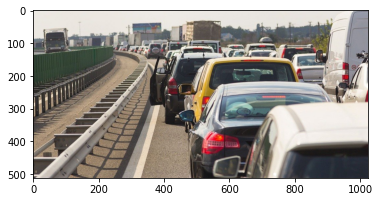

In [ ]:
img = cv2.imread('car.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(img.shape)
input_batch = transform(img).to(device)

In [ ]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

In [ ]:
pip install kornia

     |████████████████████████████████| 336 kB 5.2 MB/s 


(512, 1024)


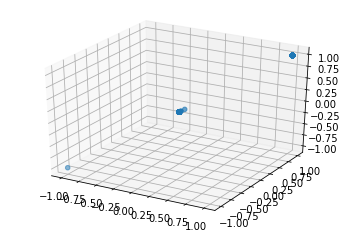

In [ ]:
from kornia.geometry.depth import depth_to_3d
from kornia.geometry.depth import depth_to_normals
import torch

print(output.shape)
d = torch.tensor(output).reshape(1,1,output.shape[0] , output.shape[1])
K = torch.eye(3)[None]
point_cloud = depth_to_normals(d , K)[0].detach().numpy()

'''
point_cloud = depth_to_3d(d, K, normalize_points = True)[0].detach().numpy()
'''
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d') 
ax.scatter(point_cloud[:,0] , point_cloud[:,1] , point_cloud[: , 2])



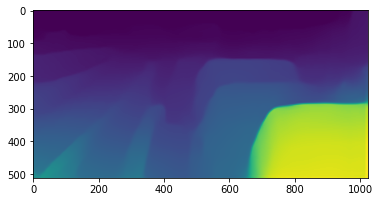

In [ ]:
plt.imshow(output)

[[   0.          0.          0.       ...   84.793686   82.86801
    82.44757 ]
 [   0.          0.          0.       ...   85.02669    83.157616
    82.74952 ]
 [   0.          0.          0.       ...   86.09112    84.48645
    84.13605 ]
 ...
 [ 828.7412    829.0184    830.36865  ... 1676.7473   1671.082
  1670.0375  ]
 [ 824.6773    824.9307    826.1284   ... 1675.9893   1669.9487
  1668.8303  ]
 [ 823.86005   824.1093    825.2781   ... 1675.8395   1669.7097
  1668.5735  ]]


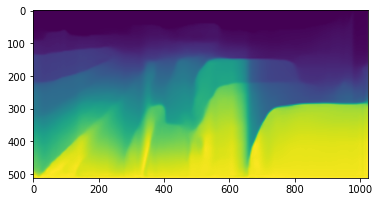

In [ ]:
from sklearn.preprocessing import MinMaxScaler
print(output)
scaler = MinMaxScaler(feature_range = (-1,1))
output = scaler.fit_transform(output)
plt.imshow(output)

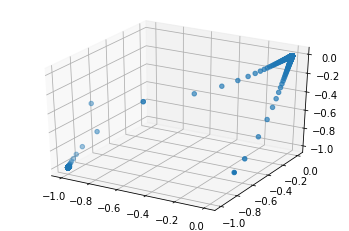

In [ ]:
d1 = torch.tensor(output).reshape(1,1,output.shape[0] , output.shape[1])
K1 = torch.eye(3)[None]
point_cloud1 = depth_to_3d(d1, K1, normalize_points = True)[0].detach().numpy()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(projection='3d') 
ax.scatter(point_cloud1[:,0] , point_cloud1[:,1] , point_cloud1[: , 2])

In [ ]:
limit = img.shape[1]/2
text = ''
if top_left[0] > limit:
  text += 'left'
  print('left')
else:
  text += 'rigth'
  print('rigth')

rigth


In [ ]:
depth_limit = 10
x_diff = bottom_right[0] - top_left[0]
print(x_diff)
ixgrid = np.ix_( range(top_left[1] , bottom_right[1]) , range(top_left[0] , bottom_right[0] ))
print(output[ixgrid].shape)
depth_image = np.sum(output[ixgrid])
print(depth_image)

if depth_image < depth_limit:
  text += ' and not near'
  print('not near')
else:
  text += 'and near'
  print('near')


57
(56, 57)
-2385.4753
not near


In [ ]:
pip install gTTS

In [ ]:
from gtts import gTTS
from IPython.display import Audio

#mytext = 'فريق رقم ثلاثه هو الفريق الاول ان شاء الله'
print(text)
language = 'en'
  
myobj = gTTS(text=text, lang=language, slow=False)
  
myobj.save("welcome.mp3")
Audio("welcome.mp3")
  

rigth and not near
